<a href="https://colab.research.google.com/github/vysf/seismologi-terapan/blob/master/Polarization_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip install obspy

In [ ]:
import numpy as np
import obspy
import pickle
import matplotlib.pyplot as plt
# from obspy.signal.polarization import polarization_analysis

# Helper Function

## Visualize helper

In [ ]:
def visualizes(stream, suptitle, trim=False, windows=[], unselected_windows=[], **kwargs):
  """
  Melakukan plot trace seismik

  Parameter
  ---------
  stream : list[obspy.core.trace.Trace]
    file seismik.

  suptitle : str
    judul plot.

  trim : bool
    menampilkan rentang data yang akan di trim

  windows : list[(start_window, end_window, window_id)]
    daftar time window yang terpilih

  unselected_windows : list[(start_window, end_window, window_id)]
    daftar time window yang tidak terpilih

  kwrags: dict
    timestart: waktu mulai
    datalength: panjang data
  """

  fig, ax = plt.subplots(3, 1, figsize=(16, 8), dpi=75, sharex=True)
  fig.suptitle(suptitle)

  for i, trace in enumerate(stream):
    time = trace.times()
    data = trace.data

    ax[i].plot(time, data)
    ax[i].set_title(trace.stats.channel[-1])
    ax[i].set_ylabel("amplitude")
    ax[i].set_xlim(min(time),max(time))
    ax[i].grid()
    if i == len(stream)-1:
      ax[i].set_xlabel("time (second)")

    if trim:
      ax[i].axvspan(kwargs['timestart'],
                    kwargs['timestart']+kwargs['datalength'],
                    color='green',
                    alpha=0.6)

    # selected windows
    if len(windows):
      for start_window, end_window, _ in windows:
        ax[i].axvspan(start_window-trace.stats.starttime,
                      end_window-trace.stats.starttime,
                      facecolor='green',
                      edgecolor='k',
                      alpha=0.3)

    # unselected windows
    if len(unselected_windows):
      for start_window, end_window, _ in unselected_windows:
        ax[i].axvspan(start_window-trace.stats.starttime,
                      end_window-trace.stats.starttime,
                      facecolor='grey',
                      edgecolor='k',
                      alpha=0.3)

In [ ]:
def visulaize_polan(trace, time_paz, polarization_data, threshold_times=None, selected_pol=None):
  labely = ['incidence','azimuth','rectilinearity','planarity']
  ylims = [[0, 90], [0, 360], [0, 1], [0, 1]]
  time = trace.times()

  colorlist = ["#C7CEDB","#7E9181","#2E3532"]
  facecolor = [colorlist[0],colorlist[1],colorlist[0],colorlist[0]]

  fig,ax = plt.subplots(4, 1,figsize=(16, 9), dpi=75, sharex=True)
  fig.suptitle("Polarization Analysis")
  for i, (paz_data, label, ylim) in enumerate(zip(polarization_data, labely, ylims)):
    if threshold_times != None and selected_pol != None:
      ax[i].scatter(time_paz, paz_data, facecolor=facecolor[i])

      if i == labely.index("azimuth"):
        ax[i].scatter(threshold_times, selected_pol[label]["intersect"], facecolor=colorlist[2], edgecolor='k')
      else:
        ax[i].scatter(selected_pol[label]["time"], selected_pol[label]["data"],facecolor = colorlist[1])
        ax[i].scatter(threshold_times, selected_pol[label]["intersect"], facecolor=colorlist[2], edgecolor='k')
        ax[i].plot([min(time_paz), max(time_paz)],[selected_pol[label]["min"], selected_pol[label]["min"]], '-.', color='grey')
    else:
      ax[i].scatter(time_paz, paz_data)

    ax[i].set_xlim(min(time), max(time))
    ax[i].set_ylabel(label)
    ax[i].set_ylim(ylim)
    ax[i].grid('both')

  ax[-1].set_xlabel("time (second)")

## Polarization helper

In [ ]:
def flinn(stream, noise_thres=0):
    """
    Computes the azimuth, incidence, rectilinearity and planarity after the
    eigenstructure decomposition method of [Flinn1965b]_.

    :param stream: ZNE sorted trace data
    :type stream: list
    :param noise_tresh: Variance of the noise sphere; data points are excluded
        when falling within the sphere of radius sqrt(noise_thres),
        default is set to 0.
    :type noise_thres: float
    :returns:  azimuth, incidence, rectilinearity, and planarity
    """
    mask = (stream[0][:] ** 2 + stream[1][:] ** 2 + stream[2][:] ** 2
            ) > noise_thres
    x = np.zeros((3, mask.sum()), dtype=np.float64)
    # East
    x[0, :] = stream[2][mask]
    # North
    x[1, :] = stream[1][mask]
    # Z
    x[2, :] = stream[0][mask]

    covmat = np.cov(x)
    eigvec, eigenval, v = np.linalg.svd(covmat)
    # Rectilinearity defined after Montalbetti & Kanasewich, 1970
    # rect = 1.0 - np.sqrt(eigenval[1] / eigenval[0])

    rect = 1.0 - ((eigenval[1]+eigenval[2])/(2*eigenval[0]))
    # Planarity defined after [Jurkevics1988]_
    plan = 1.0 - (2.0 * eigenval[2] / (eigenval[1] + eigenval[0]))
    azimuth = math.degrees(math.atan2(eigvec[0][0], eigvec[1][0]))
    eve = np.sqrt(eigvec[0][0] ** 2 + eigvec[1][0] ** 2)
    incidence = math.degrees(math.atan2(eve, eigvec[2][0]))
    if azimuth < 0.0:
      azimuth = 360.0 + azimuth
    if incidence < 0.0:
      incidence += 180.0
    if incidence > 90.0:
      incidence = 180.0 - incidence
      if azimuth > 180.0:
        azimuth -= 180.0
      else:
        azimuth += 180.0
    if azimuth > 180.0:
      azimuth -= 180.0

    return azimuth, incidence, rect, plan

In [ ]:
import math
import warnings

def _get_s_point(stream, stime, etime):
    """
    Function for computing the trace dependent start time in samples

    :param stime: time to start
    :type stime: :class:`~obspy.core.utcdatetime.UTCDateTime`
    :param etime: time to end
    :type etime: :class:`~obspy.core.utcdatetime.UTCDateTime`
    :returns: spoint, epoint
    """
    slatest = stream[0].stats.starttime
    eearliest = stream[0].stats.endtime
    for tr in stream:
      if tr.stats.starttime >= slatest:
        slatest = tr.stats.starttime
      if tr.stats.endtime <= eearliest:
        eearliest = tr.stats.endtime

    nostat = len(stream)
    spoint = np.empty(nostat, dtype=np.int32)
    epoint = np.empty(nostat, dtype=np.int32)
    # now we have to adjust to the beginning of real start time
    if slatest > stime:
      msg = "Specified start time is before latest start time in stream"
      raise ValueError(msg)
    if eearliest < etime:
      msg = "Specified end time is after earliest end time in stream"
      raise ValueError(msg)
    for i in range(nostat):
      offset = int(((stime - slatest) / stream[i].stats.delta + 1.))
      negoffset = int(((eearliest - etime) / stream[i].stats.delta + 1.))
      diffstart = slatest - stream[i].stats.starttime
      frac, _ = math.modf(diffstart)
      spoint[i] = int(diffstart)
      if frac > stream[i].stats.delta * 0.25:
        msg = "Difference in start times exceeds 25% of sampling rate"
        warnings.warn(msg)
      spoint[i] += offset
      diffend = stream[i].stats.endtime - eearliest
      frac, _ = math.modf(diffend)
      epoint[i] = int(diffend)
      epoint[i] += negoffset

    return spoint, epoint

In [ ]:
from obspy.signal.invsim import cosine_taper

def polarization_analysis(stream, win_len, win_frac, stime,
                          etime, var_noise=0.0,
                          ):

    res = []

    fs = stream[0].stats.sampling_rate

    spoint, _epoint = _get_s_point(stream, stime, etime)

    nsamp = int(win_len * fs)
    nstep = int(nsamp * win_frac)
    newstart = stime
    tap = cosine_taper(nsamp, p=0.22)
    offset = 0
    while (newstart + (nsamp + nstep) / fs) < etime:
      timestamp = newstart.timestamp + (float(nsamp) / 2 / fs)
      try:
        for i, tr in enumerate(stream):
          dat = tr.data[spoint[i] + offset:
                        spoint[i] + offset + nsamp]
          dat = (dat - dat.mean()) * tap
          if tr.stats.channel[-1].upper() == "Z":
            z = dat.copy()
          elif tr.stats.channel[-1].upper() == "N":
            n = dat.copy()
          elif tr.stats.channel[-1].upper() == "E":
            e = dat.copy()
          else:
            msg = "Unexpected channel code '%s'" % tr.stats.channel
            raise ValueError(msg)

        data = [z, n, e]
      except IndexError:
        break

      # we plot against the centre of the sliding window
      azimuth, incidence, reclin, plan = flinn(data, var_noise)
      res.append(np.array([
          timestamp, azimuth, incidence, reclin, plan]))

      offset += nstep

      newstart += float(nstep) / fs

    res = np.array(res)

    result_dict = {"timestamp": res[:, 0],
                   "azimuth": res[:, 1],
                   "incidence": res[:, 2]}
    result_dict["rectilinearity"] = res[:, 3]
    result_dict["planarity"] = res[:, 4]

    return result_dict

In [ ]:
def streamCheck(st):
  if st.select(component="Z") and st.select(component="N") and st.select(component="E"):
    return True
  else:
    return False

In [ ]:
def polarization(st, winlen=20):
  if not streamCheck:
    return None
  result = polarization_analysis(st,winlen,1,st[0].stats.starttime,st[0].stats.endtime)
  for i,item in enumerate(result['incidence']):
    result['incidence'][i] = 90-abs(item)
  return result

# Read Data

In [ ]:
observed_file = "temporary_prepro.mseed"
window_list_file = "window_list_prepro.pkl"

## Data observation

In [ ]:
stream = obspy.read(observed_file)

print("SEISMOGRAM INFORMATION")
print(stream[2].stats)

SEISMOGRAM INFORMATION
         network: HG
         station: 16
        location: 
         channel: BHZ
       starttime: 2022-07-28T05:53:42.340000Z
         endtime: 2022-07-28T07:08:42.340000Z
   sampling_rate: 100.0
           delta: 0.01
            npts: 450001
           calib: 1.0
         _format: MSEED
           mseed: AttribDict({'dataquality': 'D', 'number_of_records': 7895, 'encoding': 'FLOAT64', 'byteorder': '>', 'record_length': 512, 'filesize': 12126720})


## Windows file

In [ ]:
with open(window_list_file, 'rb') as fi:
  window_list = pickle.load(fi)

print("WINDOW INFORMATION")
print(f"Number of windows: {len(window_list)}, total time: {len(window_list)*window_length/60} minutes")

WINDOW INFORMATION
Number of windows: 273, total time: 45.5 minutes


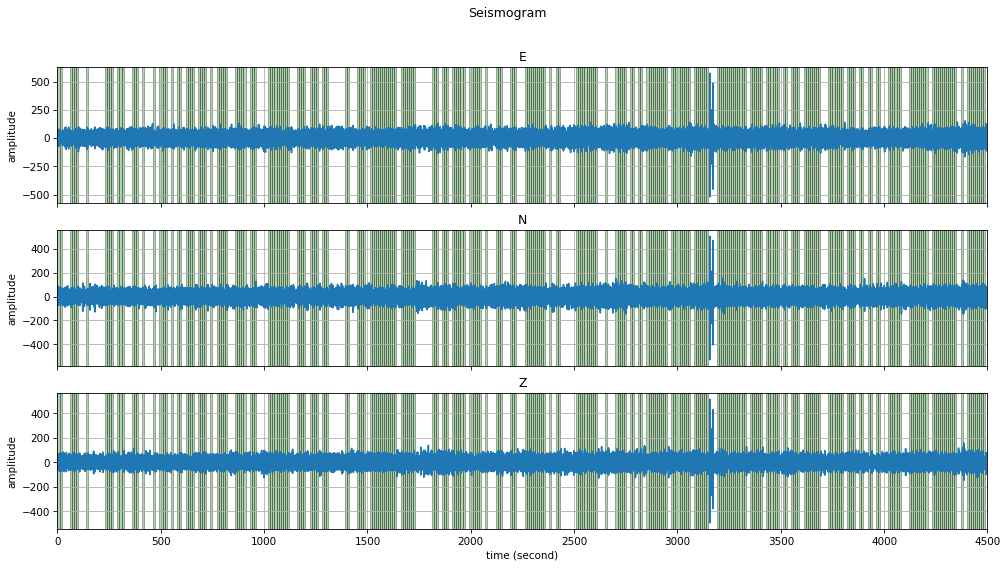

In [ ]:
visualizes(stream, "Seismogram", windows=window_list)

# Polarization Analysis

In [ ]:
window_length = 10 # in seconds
paz = polarization(stream, window_length)
paz.keys()

dict_keys(['timestamp', 'azimuth', 'incidence', 'rectilinearity', 'planarity'])

Atur ulang posisi data

In [ ]:
polarization_data = [paz['incidence'], paz['azimuth'],
                     paz['rectilinearity'], paz['planarity']]

buat Δt dari hasil analisis polarisasi dengan waktu mulai trace

In [ ]:
time_paz = []
for i in range(len(paz['timestamp'])):
  time_paz.append(obspy.UTCDateTime(paz['timestamp'][i])-stream[0].stats.starttime)

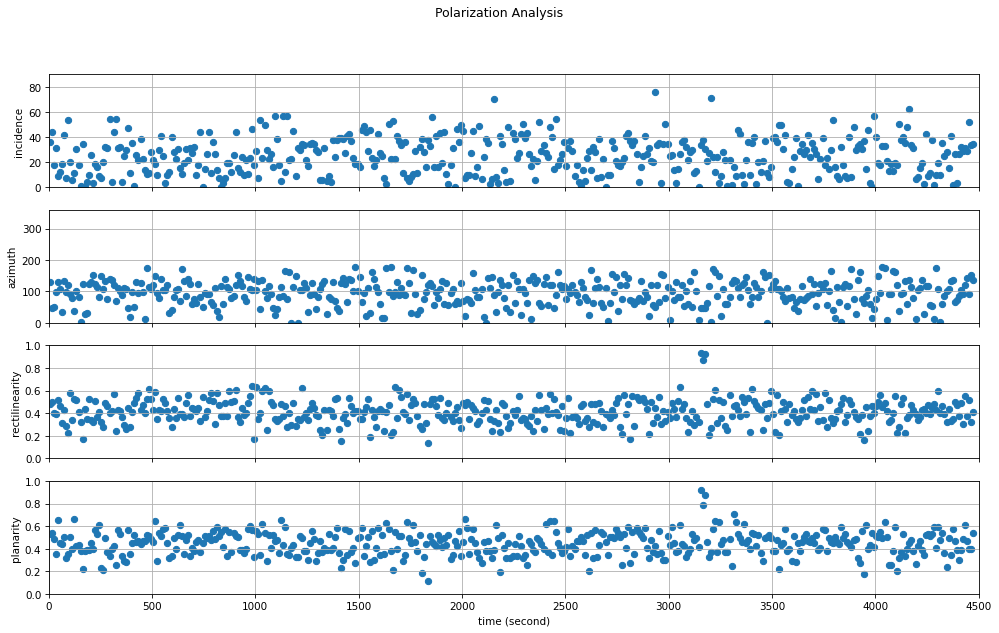

In [ ]:
visulaize_polan(stream[0], time_paz, polarization_data)

Lakukan batasan (thresholding) pada komponen polarisasi. bertujuan untuk menyaring window mana saja yang akan digunakan pada proses selanjutnya.

In [ ]:
# incidence
minimum_incidence_angle = 40
maximum_incidence_angle = 90

# rectilinearity
minimum_rectilinearity = 0.45
maximum_rectilinearity = 1.0

# planarity
minimum_planarity = 0.4
maximum_planarity = 1.0

Pilih komponen dan waktu polarisasi sepanjang banyak datanya berdasarkan window id

In [ ]:
# list[(start_window, end_window, window_id)]

_inc = []; _azi = []; _rect = []; _plan = []; _time = []
for i in range(len(window_list)):
  iwl = window_list[i][2]
  if iwl < len(polarization_data[0]):
    _inc.append(polarization_data[0][iwl])
    _azi.append(polarization_data[1][iwl])
    _rect.append(polarization_data[2][iwl])
    _plan.append(polarization_data[3][iwl])
    _time.append(time_paz[iwl])

Atur ulang posisi data yang telah di pilih

In [ ]:
polarization_data = [_inc,_azi,_rect,_plan]
time_paz = _time.copy()

## incidence thresholding



> i = index \
> d = data \
> t = time \
>
> contoh: iinc = index incident, dinc = data incident, dan tinc = time incident



In [ ]:
inc  = polarization_data[0]
iinc = []
dinc = []
tinc = []
for i,_inc in enumerate(inc):
  if _inc >= minimum_incidence_angle and _inc <= maximum_incidence_angle:
    iinc.append(i)
    dinc.append(_inc)
    tinc.append(time_paz[i])

In [ ]:
# azimuth thresholding
# silahkan dicoba isi sendiri

## rectilinearity thresholding

In [ ]:
rect = polarization_data[2]
irect= []
drect = []
trect = []
for i,_rect in enumerate(rect):
  if _rect >= minimum_rectilinearity and _rect <= maximum_rectilinearity:
    irect.append(i)
    drect.append(_rect)
    trect.append(time_paz[i])

## planarity thresholding

In [ ]:
plan = polarization_data[3]
iplan= []
dplan = []
tplan = []
for i,_plan in enumerate(plan):
  if _plan >= minimum_planarity and _plan <= maximum_planarity:
    iplan.append(i)
    dplan.append(_plan)
    tplan.append(time_paz[i])

## integrated thresholding



In [ ]:
def intersection(lst1, lst2):
  return list(set(lst1) & set(lst2))

Ambil nilai-nilai berdasarkan index yang beririsan (intersect) antara incident, rectiliniarty dan planarity

In [ ]:
dinc_a = []
dazi_a = []
drect_a = []
dplan_a = []
tthres = []
_list = intersection(iinc,irect)
_list = intersection(_list,iplan)
for i,_ithres in enumerate(_list):
  dinc_a.append(polarization_data[0][_ithres])
  dazi_a.append(polarization_data[1][_ithres])
  drect_a.append(polarization_data[2][_ithres])
  dplan_a.append(polarization_data[3][_ithres])
  tthres.append(time_paz[_ithres])

In [ ]:
selected_pol = {
  "incidence": {
    "time": tinc,
    "data": dinc,
    "intersect": dinc_a,
    "min": minimum_incidence_angle,
    "max": maximum_incidence_angle
  },
  "azimuth": {
    "intersect": dinc_a,
  },
  "rectilinearity": {
    "time": trect,
    "data": drect,
    "intersect": drect_a,
    "min": minimum_rectilinearity,
    "max": minimum_rectilinearity
  },
  "planarity": {
    "time": tplan,
    "data": dplan,
    "intersect": drect_a,
    "min": minimum_planarity,
    "max": minimum_planarity
  },
}

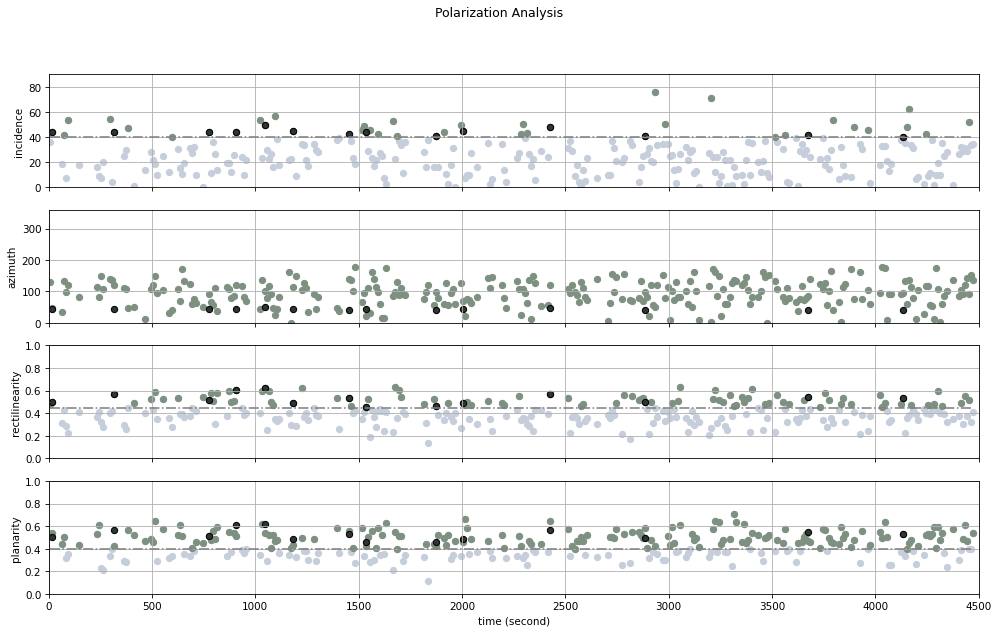

In [ ]:
visulaize_polan(stream[0], time_paz, polarization_data, tthres, selected_pol)

susun ulang komponen window yang sudah diseleksi

In [ ]:
# window list
_tmp = []
for i in range(len(_list)):
  _tmp.append(window_list[_list[i]])

# Save Output File
simpan file daftar window tersebut

In [ ]:
window_list_polans = _tmp.copy()
with open('window_list_polans.pkl','wb') as fo:
  pickle.dump(window_list_polans, fo)

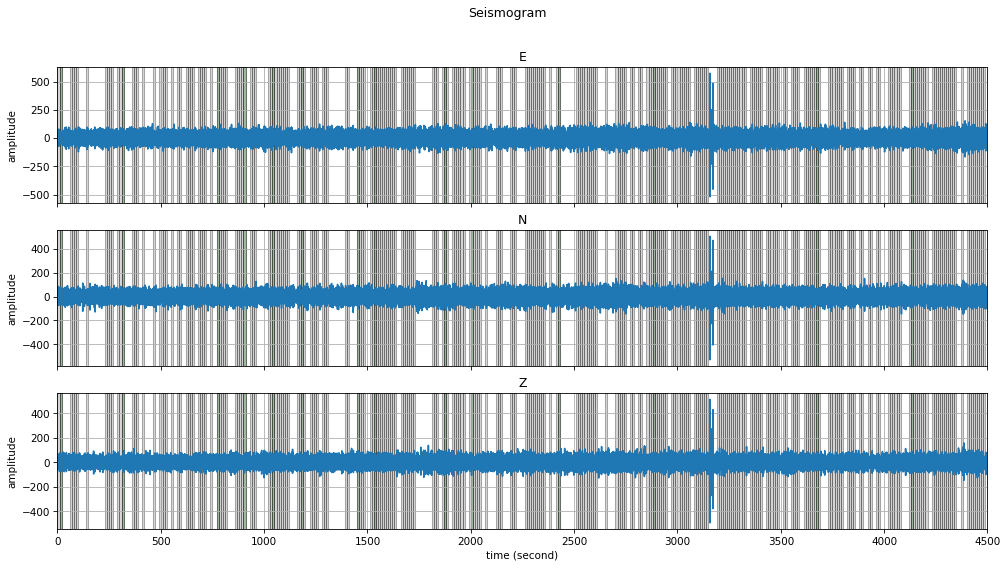

In [ ]:
visualizes(stream, "Seismogram", windows=window_list_polans, unselected_windows=window_list)

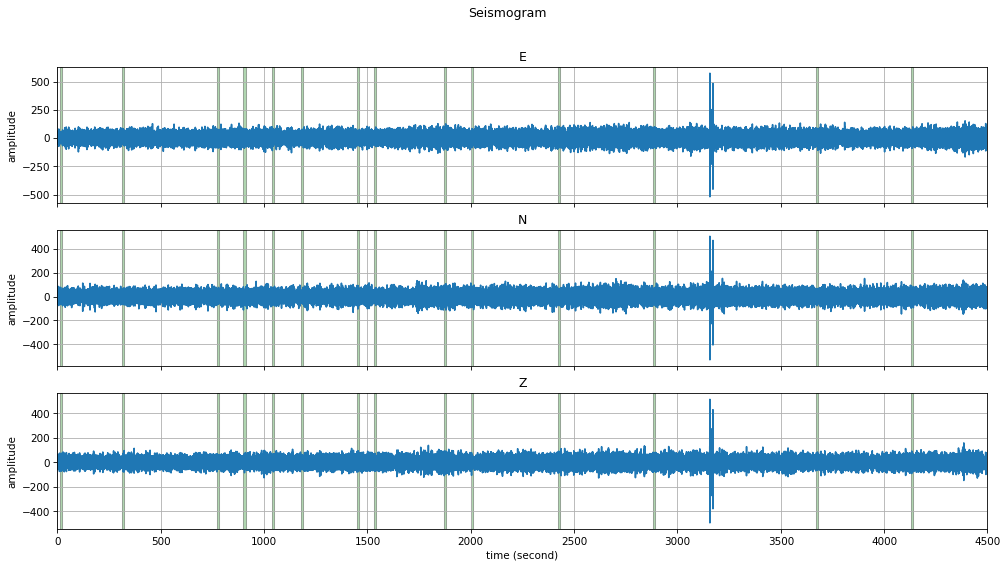

In [ ]:
visualizes(stream, "Seismogram", windows=window_list_polans)